In [1]:
from bs4 import BeautifulSoup,Comment
import urllib.request
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
#from pandas import DataFrame as df

In [ ]:
#to get soup for 2020 team offense using Comment, used below
url = "https://www.pro-football-reference.com/years/2020/"
soup = BeautifulSoup(requests.get(url).content, 'html.parser')
table = soup.select_one('#all_team_stats').find_next(text=lambda t: isinstance(t, Comment))
table = BeautifulSoup(table, 'html.parser')



In [ ]:
#what the HTML looks like
table.prettify()[0:2500]

In [7]:
#function to rename some columns and columns that are missing titles from HTML table
def rename_cols(df):
    dict = {'Unnamed: 0_level_0':'TotOff',
            'Unnamed: 1_level_0':'TotOff',
            'Unnamed: 2_level_0':'TotOff',
            'Unnamed: 3_level_0':'TotOff',
            'Unnamed: 4_level_0':'TotOff',
            'Tot Yds & TO':'TotOff',
            'Tot Yds & TO':'TotOff',
            'Tot Yds & TO':'TotOff',
            'Unnamed: 8_level_0':'TotOff',
            'Unnamed: 9_level_0':'TotOff',
            'Unnamed: 25_level_0':'Score%',
            'Unnamed: 26_level_0':'TurnOver%',
            'Unnamed: 27_level_0':'EXP',}
        
    # call rename() method
    df.rename(columns=dict,inplace=True)
    return(df)


In [337]:
#for loop to get data for X years


year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
OFFdfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.select_one('#all_team_stats').find_next(text=lambda t: isinstance(t, Comment))
    table = BeautifulSoup(table, 'html.parser')    
    #create DF from html table, drop last 3 rows of data 
    OFFdf = pd.read_html(str(table))[0]
    curr_year = year - count
    OFFdf['Year'] = curr_year
    OFFdfs.append(OFFdf[:-3])
    count+=1


#initialize Master Team Offense Dataframe    
MasterOFF = OFFdfs[0]

for i in range(len(OFFdfs)-1):    
    #append DF to master, reset index to continuous
    MasterOFF = MasterOFF.append(OFFdfs[i+1],ignore_index = True)

#rename columns to useful index    
MasterOFF = rename_cols(MasterOFF)



In [ ]:
MasterOFF.info()

In [338]:
MasterOFF.tail(32)

TotOff                                                                \
        Rk                    Tm     G     PF     Yds     Ply  Y/P    TO   
288    1.0     Green Bay Packers  16.0  560.0  6482.0   988.0  6.6  14.0   
289    2.0    New Orleans Saints  16.0  547.0  7474.0  1117.0  6.7  19.0   
290    3.0  New England Patriots  16.0  513.0  6848.0  1082.0  6.3  17.0   
291    4.0         Detroit Lions  16.0  474.0  6337.0  1058.0  6.0  23.0   
292    5.0     Carolina Panthers  16.0  406.0  6237.0   999.0  6.2  23.0   
293    6.0    San Diego Chargers  16.0  406.0  6290.0  1048.0  6.0  28.0   
294    7.0       Atlanta Falcons  16.0  402.0  6026.0  1073.0  5.6  21.0   
295    8.0   Philadelphia Eagles  16.0  396.0  6386.0  1036.0  6.2  38.0   
296    9.0       New York Giants  16.0  394.0  6161.0  1028.0  6.0  24.0   
297   10.0        Houston Texans  16.0  381.0  5954.0  1046.0  5.7  20.0   
298   11.0   San Francisco 49ers  16.0  380.0  4974.0   993.0  5.0  10.0   
299   12.0      Baltimore Ravens  16.0  378.0  5419.0  1036.0  5.2  24.0   
300   13.0         New York Jets  16.0  377.0  4989.0  1030.0  4.8  34.0   
301   14.0         Buffalo Bills  16.0  372.0  5624.0   992.0  5.7  30.0   
302   15.0        Dallas Cowboys  16.0  369.0  6008.0  1017.0  5.9  21.0   
303   16.0       Oakland Raiders  16.0  359.0  6072.0  1015.0  6.0  30.0   
304   17.0         Chicago Bears  16.0  353.0  5026.0   978.0  5.1  29.0   
305   18.0    Cincinnati Bengals  16.0  344.0  5118.0  1015.0  5.0  22.0   
306   19.0     Minnesota Vikings  16.0  340.0  5275.0  1007.0  5.2  26.0   
307   20.0        Miami Dolphins  16.0  329.0  5078.0   990.0  5.1  25.0   
308   21.0      Tennessee Titans  16.0  325.0  5361.0   984.0  5.4  22.0   
309   22.0   Pittsburgh Steelers  16.0  325.0  5957.0  1015.0  5.9  28.0   
310   23.0      Seattle Seahawks  16.0  321.0  4861.0  1003.0  4.8  23.0   
311   24.0     Arizona Cardinals  16.0  312.0  5192.0   993.0  5.2  32.0   
312   25.0        Denver Broncos  16.0  309.0  5066.0  1017.0  5.0  30.0   
313   26.0   Washington Redskins  16.0  288.0  5387.0  1032.0  5.2  35.0   
314   27.0  Tampa Bay Buccaneers  16.0  287.0  5108.0   966.0  5.3  40.0   
315   28.0  Jacksonville Jaguars  16.0  243.0  4149.0  1002.0  4.1  23.0   
316   29.0    Indianapolis Colts  16.0  243.0  4589.0   951.0  4.8  29.0   
317   30.0      Cleveland Browns  16.0  218.0  4621.0  1024.0  4.5  19.0   
318   31.0    Kansas City Chiefs  16.0  212.0  4973.0  1021.0  4.9  28.0   
319   32.0        St. Louis Rams  16.0  193.0  4537.0  1013.0  4.5  23.0   

                  ... Rushing             Penalties               Score%  \
       FL   1stD  ...      TD  Y/A   1stD       Pen     Yds 1stPy    Sc%   
288   6.0  353.0  ...    12.0  3.9   89.0      76.0   591.0  34.0   48.3   
289   5.0  416.0  ...    16.0  4.9  116.0      99.0   851.0  20.0   51.4   
290   5.0  399.0  ...    18.0  4.0  107.0      87.0   815.0  30.0   47.2   
291   7.0  349.0  ...     9.0  4.3   71.0     128.0  1075.0  34.0   37.6   
292   6.0  345.0  ...    26.0  5.4  139.0     113.0  1013.0  31.0   38.5   
293   8.0  359.0  ...    16.0  4.3   97.0      91.0   753.0  28.0   41.3   
294   8.0  349.0  ...    14.0  4.0  100.0      93.0   769.0  34.0   37.4   
295  13.0  356.0  ...    20.0  5.1  134.0     107.0   853.0  25.0   34.7   
296   8.0  331.0  ...    17.0  3.5   84.0      94.0   795.0  31.0   32.5   
297  11.0  321.0  ...    18.0  4.5  131.0      99.0   852.0  14.0   37.2   
298   5.0  282.0  ...    14.0  4.1  101.0     113.0  1014.0  31.0   39.6   
299  12.0  312.0  ...    15.0  4.3   98.0      92.0   742.0  33.0   35.5   
300  16.0  301.0  ...    14.0  3.8   92.0     102.0   849.0  36.0   29.6   
301   5.0  313.0  ...    12.0  4.9  100.0      86.0   743.0  33.0   31.2   
302   9.0  327.0  ...     5.0  4.4   91.0     114.0   816.0  17.0   37.8   
303   7.0  328.0  ...    16.0  4.5  110.0     163.0  1358.0  32.0   34.7   
304   9.0  271.0  ...    10.0  4.4   97.0     104.0

In [160]:
MasterOFF.keys()

MultiIndex([(   'TotOff',    'Rk'),
            (   'TotOff',    'Tm'),
            (   'TotOff',     'G'),
            (   'TotOff',    'PF'),
            (   'TotOff',   'Yds'),
            (   'TotOff',   'Ply'),
            (   'TotOff',   'Y/P'),
            (   'TotOff',    'TO'),
            (   'TotOff',    'FL'),
            (   'TotOff',  '1stD'),
            (  'Passing',   'Cmp'),
            (  'Passing',   'Att'),
            (  'Passing',   'Yds'),
            (  'Passing',    'TD'),
            (  'Passing',   'Int'),
            (  'Passing',  'NY/A'),
            (  'Passing',  '1stD'),
            (  'Rushing',   'Att'),
            (  'Rushing',   'Yds'),
            (  'Rushing',    'TD'),
            (  'Rushing',   'Y/A'),
            (  'Rushing',  '1stD'),
            ('Penalties',   'Pen'),
            ('Penalties',   'Yds'),
            ('Penalties', '1stPy'),
            (   'Score%',   'Sc%'),
            ('TurnOver%',   'TO%'),
            (      'EXP',   

In [ ]:
plt.figure(figsize=(10, 10))
#pointsfor = MasterOFF.TotOff.PF
MasterOFF.plot.scatter("Year", [('TotOff','PF')] , figsize=(15, 10))
plt.show()

In [71]:
#Get Team Defense data

year = 2020
#number of years
n=10
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
DEFdfs = []
ADV_DEFdf = []
Team_Sacks = pd.DataFrame(['Tm','Sk'])
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/opp.htm')
    years = year - index

    
#mask for advanced_defense table data
sacks = ['Tm','Sk']

#team_stats table does not include Sacks, so need passing table data and merge tables.
count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.find('table', id = 'team_stats') 
    #table2 = soup.select('table', id = 'passing')
    table2 = soup.select_one('#all_passing').find_next(text=lambda t: isinstance(t, Comment))
    table2 = BeautifulSoup(table2, 'html.parser')
    #create DF from html table, drop last 3 rows of data 
    DEFdf = pd.read_html(str(table))[0]
    DEFdf.drop(DEFdf.tail(3).index, inplace = True)
    #rename each DF
    rename_cols(DEFdf)
    #sort alphabetically
    DEFdf.sort_values([('TotOff', 'Tm')],inplace=True)
    ADV_DEFdf = pd.read_html(str(table2))[0]
    ADV_DEFdf.drop(ADV_DEFdf.tail(3).index,inplace = True)
    #apply mask
    Team_Sacks = ADV_DEFdf[sacks].copy()
    #sort alphabetically
    Team_Sacks.sort_values(['Tm'],inplace = True)
    #intermediate step prior to appending data. merges team_stats and team sacks data 
    DEFdf_interm = pd.merge(DEFdf,Team_Sacks, left_on =[('TotOff', 'Tm')], right_on = 'Tm' )
    #append to list of team defense data
    curr_year = year - count
    DEFdf_interm['Year'] = curr_year    
    DEFdfs.append(DEFdf_interm)
    count+=1


#initialize master DataFrame with first list of Team Defense data
MasterDEF = DEFdfs[0]

for i in range(len(DEFdfs)-1):    
    #append DF to master, reset index to continuous
    MasterDEF = MasterDEF.append(DEFdfs[i+1],ignore_index = True)
    
MasterDEF.drop('Tm',axis = 1,inplace=True)

MasterDEF.head(5)

/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/Users/scottstack/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/Users/scottstack/opt/anaconda3/

,"(TotOff, Rk)","(TotOff, Tm)","(TotOff, G)","(TotOff, PF)","(TotOff, Yds)","(TotOff, Ply)","(TotOff, Y/P)","(TotOff, TO)","(TotOff, FL)","(TotOff, 1stD)",...,"(Rushing, Y/A)","(Rushing, 1stD)","(Penalties, Pen)","(Penalties, Yds)","(Penalties, 1stPy)","(Score%, Sc%)","(TurnOver%, TO%)","(EXP, EXP)",Sk,Year
0,12.0,Arizona Cardinals,16.0,367.0,5631.0,1054.0,5.3,21.0,10.0,363.0,...,4.6,118.0,104.0,841.0,38.0,37.2,10.5,-82.04,48.0,2020
1,19.0,Atlanta Falcons,16.0,414.0,6374.0,1034.0,6.2,21.0,9.0,367.0,...,4.4,97.0,91.0,800.0,31.0,42.0,12.1,-148.58,29.0,2020
2,2.0,Baltimore Ravens,16.0,303.0,5276.0,1017.0,5.2,22.0,12.0,347.0,...,4.6,96.0,77.0,646.0,38.0,30.0,12.4,-17.69,39.0,2020
3,16.0,Buffalo Bills,16.0,375.0,5640.0,1025.0,5.5,26.0,11.0,351.0,...,4.6,125.0,86.0,728.0,27.0,39.4,15.3,-123.10,38.0,2020
4,18.0,Carolina Panthers,16.0,402.0,5761.0,1022.0,5.6,22.0,15.0,360.0,...,4.7,114.0,85.0,713.0,35.0,46.0,12.4,-125.54,29.0,2020


In [72]:
MasterDEF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (TotOff, Rk)        320 non-null    float64
 1   (TotOff, Tm)        320 non-null    object 
 2   (TotOff, G)         320 non-null    float64
 3   (TotOff, PF)        320 non-null    float64
 4   (TotOff, Yds)       320 non-null    float64
 5   (TotOff, Ply)       320 non-null    float64
 6   (TotOff, Y/P)       320 non-null    float64
 7   (TotOff, TO)        320 non-null    float64
 8   (TotOff, FL)        320 non-null    float64
 9   (TotOff, 1stD)      320 non-null    float64
 10  (Passing, Cmp)      320 non-null    float64
 11  (Passing, Att)      320 non-null    float64
 12  (Passing, Yds)      320 non-null    float64
 13  (Passing, TD)       320 non-null    float64
 14  (Passing, Int)      320 non-null    float64
 15  (Passing, NY/A)     320 non-null    float64
 16  (Passing

In [73]:
MasterDEF.keys()

Index([      ('TotOff', 'Rk'),       ('TotOff', 'Tm'),        ('TotOff', 'G'),
             ('TotOff', 'PF'),      ('TotOff', 'Yds'),      ('TotOff', 'Ply'),
            ('TotOff', 'Y/P'),       ('TotOff', 'TO'),       ('TotOff', 'FL'),
           ('TotOff', '1stD'),     ('Passing', 'Cmp'),     ('Passing', 'Att'),
           ('Passing', 'Yds'),      ('Passing', 'TD'),     ('Passing', 'Int'),
          ('Passing', 'NY/A'),    ('Passing', '1stD'),     ('Rushing', 'Att'),
           ('Rushing', 'Yds'),      ('Rushing', 'TD'),     ('Rushing', 'Y/A'),
          ('Rushing', '1stD'),   ('Penalties', 'Pen'),   ('Penalties', 'Yds'),
       ('Penalties', '1stPy'),      ('Score%', 'Sc%'),   ('TurnOver%', 'TO%'),
               ('EXP', 'EXP'),                   'Sk',                 'Year'],
      dtype='object')

In [128]:
#for loop to get data for X years

#get standings inlcuding win-loss record

year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
AFCStandDfs = []
NFCStandDfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    AFCtable = soup.select('table', id='AFC')
    NFCtable = soup.select('table', id='NFC')
    AFCStandDf = pd.read_html(str(AFCtable))[0]
    NFCStandDf = pd.read_html(str(NFCtable))[0]
    curr_year = year - count
    AFCStandDf['Year'] = curr_year
    AFCStandDfs.append(AFCStandDf)
    NFCStandDf['Year'] = curr_year
    NFCStandDfs.append(NFCStandDf)    
    count+=1


#initialize Dataframe    
AFCStandings = AFCStandDfs[0]
NFCStandings = NFCStandDfs[0]
for i in range(len(AFCStandDfs)-1):    
    #append DF, reset index to continuous
    AFCStandings = AFCStandings.append(AFCStandDfs[i+1],ignore_index = True)
    NFCStandings = NFCStandings.append(NFCStandDfs[i+1],ignore_index = True)

#drop conference labels (north,east,west,south)    
AFCStandings.drop(AFCStandings.index[0:len(AFCStandings):5], inplace = True)
NFCStandings.drop(NFCStandings.index[0:len(NFCStandings):5], inplace = True)


In [157]:
AFCStandings.head()

,Tm,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,Year
1,Buffalo Bills*,13,3,0,.813,501,375,126,7.9,-0.2,7.7,7.1,0.6,2020
2,Miami Dolphins,10,6,0,.625,404,338,66,4.1,-1.2,3.0,0.3,2.7,2020
3,New England Patriots,7,9,0,.438,326,353,-27,-1.7,0.7,-1.0,-4.2,3.2,2020
4,New York Jets,2,14,0,.125,243,457,-214,-13.4,1.9,-11.5,-8.7,-2.8,2020
6,Pittsburgh Steelers*,12,4,0,.750,416,312,104,6.5,-1.8,4.7,0.3,4.4,2020


In [158]:
NFCStandings.head()

,Tm,W,L,T,W-L%,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,Year
1,Buffalo Bills*,13,3,0,.813,501,375,126,7.9,-0.2,7.7,7.1,0.6,2020
2,Miami Dolphins,10,6,0,.625,404,338,66,4.1,-1.2,3.0,0.3,2.7,2020
3,New England Patriots,7,9,0,.438,326,353,-27,-1.7,0.7,-1.0,-4.2,3.2,2020
4,New York Jets,2,14,0,.125,243,457,-214,-13.4,1.9,-11.5,-8.7,-2.8,2020
6,Pittsburgh Steelers*,12,4,0,.750,416,312,104,6.5,-1.8,4.7,0.3,4.4,2020


In [139]:
#get playoff results data
#includes winner and score

#for loop to get data for X years


year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
PlayOffdfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.select_one('#all_playoff_results').find_next(text=lambda t: isinstance(t, Comment))
    table = BeautifulSoup(table, 'html.parser') 
    PlayOffdf = pd.read_html(str(table))[0]
    curr_year = year - count
    PlayOffdf['Year'] = curr_year
    PlayOffdfs.append(PlayOffdf)
    count+=1


#initialize Playoffs Dataframe    
PlayOffs = PlayOffdfs[0]

for i in range(len(PlayOffdfs)-1):    
    #append DF, reset index to continuous
    PlayOffs = PlayOffs.append(PlayOffdfs[i+1],ignore_index = True)





In [137]:
PlayOffs.head(13)

,Week,Day,Date,Winner/tie,Unnamed: 4,Loser/tie,Unnamed: 6,Pts,Pts.1,Year
0,WildCard,Sat,2021-01-09,Buffalo Bills,NaN,Indianapolis Colts,boxscore,27,24,2020
1,WildCard,Sat,2021-01-09,Los Angeles Rams,@,Seattle Seahawks,boxscore,30,20,2020
2,WildCard,Sat,2021-01-09,Tampa Bay Buccaneers,@,Washington Football Team,boxscore,31,23,2020
3,WildCard,Sun,2021-01-10,Cleveland Browns,@,Pittsburgh Steelers,boxscore,48,37,2020
4,WildCard,Sun,2021-01-10,New Orleans Saints,NaN,Chicago Bears,boxscore,21,9,2020
5,WildCard,Sun,2021-01-10,Baltimore Ravens,@,Tennessee Titans,boxscore,20,13,2020
6,Division,Sat,2021-01-16,Green Bay Packers,NaN,Los Angeles Rams,boxscore,32,18,2020
7,Division,Sat,2021-01-16,Buffalo Bills,NaN,Baltimore Ravens,boxscore,17,3,2020
8,Division,Sun,2021-01-17,Kansas City Chiefs,NaN,Cleveland Browns,boxscore,22,17,2020
9,Division,Sun,2021-01-17,Tampa Bay Buccaneers,@,New Orleans Saints,boxscore,30,20,2020


In [141]:
PlayOffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Week        112 non-null    object
 1   Day         112 non-null    object
 2   Date        112 non-null    object
 3   Winner/tie  112 non-null    object
 4   Unnamed: 4  46 non-null     object
 5   Loser/tie   112 non-null    object
 6   Unnamed: 6  112 non-null    object
 7   Pts         112 non-null    int64 
 8   Pts.1       112 non-null    int64 
 9   Year        112 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 8.9+ KB


In [144]:
PlayOffs.keys()

Index(['Week', 'Day', 'Date', 'Winner/tie', 'Unnamed: 4', 'Loser/tie',
       'Unnamed: 6', 'Pts', 'Pts.1', 'Year'],
      dtype='object')

In [155]:
SBWinner = PlayOffs.loc[PlayOffs['Week']=='SuperBowl']

In [156]:
SBWinner

,Week,Day,Date,Winner/tie,Unnamed: 4,Loser/tie,Unnamed: 6,Pts,Pts.1,Year
12,SuperBowl,Sun,2021-02-07,Tampa Bay Buccaneers,N,Kansas City Chiefs,boxscore,31,9,2020
23,SuperBowl,Sun,2020-02-02,Kansas City Chiefs,N,San Francisco 49ers,boxscore,31,20,2019
34,SuperBowl,Sun,2019-02-03,New England Patriots,N,Los Angeles Rams,boxscore,13,3,2018
45,SuperBowl,Sun,2018-02-04,Philadelphia Eagles,N,New England Patriots,boxscore,41,33,2017
56,SuperBowl,Sun,2017-02-05,New England Patriots,N,Atlanta Falcons,boxscore,34,28,2016
67,SuperBowl,Sun,2016-02-07,Denver Broncos,N,Carolina Panthers,boxscore,24,10,2015
78,SuperBowl,Sun,2015-02-01,New England Patriots,N,Seattle Seahawks,boxscore,28,24,2014
89,SuperBowl,Sun,2014-02-02,Seattle Seahawks,N,Denver Broncos,boxscore,43,8,2013
100,SuperBowl,Sun,2013-02-03,Baltimore Ravens,N,San Francisco 49ers,boxscore,34,31,2012
111,SuperBowl,Sun,2012-02-05,New York Giants,N,New England Patriots,boxscore,21,17,2011


In [343]:
#assigning binary superbowl win column to master team offense dataframe.
#this block should be put into a for loop

MasterOFF[('SB','Win')] = 0

row = MasterOFF.loc[(MasterOFF[('TotOff','Tm')] == 'Tampa Bay Buccaneers') & (MasterOFF['Year'] == 2020)].index
MasterOFF.at[row[0],('SB','Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff','Tm')] == 'Kansas City Chiefs') & (MasterOFF['Year'] == 2019)].index
MasterOFF.at[row[0],('SB','Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff','Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2018)].index
MasterOFF.at[row[0],('SB','Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff','Tm')] == 'Philadelphia Eagles') & (MasterOFF['Year'] == 2017)].index
MasterOFF.at[row[0],('SB','Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff','Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2016)].index
MasterOFF.at[row[0],('SB','Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff','Tm')] == 'Denver Broncos') & (MasterOFF['Year'] == 2015)].index
MasterOFF.at[row[0],('SB','Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff','Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2014)].index
MasterOFF.at[row[0],('SB','Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff','Tm')] == 'Seattle Seahawks') & (MasterOFF['Year'] == 2013)].index
MasterOFF.at[row[0],('SB','Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff','Tm')] == 'Baltimore Ravens') & (MasterOFF['Year'] == 2012)].index
MasterOFF.at[row[0],('SB','Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff','Tm')] == 'New York Giants') & (MasterOFF['Year'] == 2011)].index
MasterOFF.at[row[0],('SB','Win')] = 1


MasterOFF.head(5)


TotOff                                                                      \
      Rk                    Tm     G     PF     Yds     Ply  Y/P    TO    FL   
0    1.0     Green Bay Packers  16.0  509.0  6224.0   990.0  6.3  11.0   6.0   
1    2.0         Buffalo Bills  16.0  501.0  6343.0  1034.0  6.1  22.0  11.0   
2    3.0  Tampa Bay Buccaneers  16.0  492.0  6145.0  1017.0  6.0  17.0   5.0   
3    4.0      Tennessee Titans  16.0  491.0  6343.0  1031.0  6.2  12.0   5.0   
4    5.0    New Orleans Saints  16.0  482.0  6023.0  1045.0  5.8  17.0   9.0   

          ... Rushing        Penalties               Score% TurnOver%     EXP  \
    1stD  ...     Y/A   1stD       Pen     Yds 1stPy    Sc%       TO%     EXP   
0  358.0  ...     4.8  114.0      84.0   684.0  28.0   49.7       5.6  290.75   
1  397.0  ...     4.2  119.0     102.0   941.0  38.0   49.4      11.8  228.66   
2  364.0  ...     4.1   82.0      84.0   715.0  44.0   47.8       8.9  246.24   
3  381.0  ...     5.2  142.0      86.0   783.0  36.0   47.9       7.2  245.01   
4  367.0  ...     4.6  147.0      98.0  1005.0  21.0   45.5       9.0  176.94   

   Year  SB  
        Win  
0  2020   0  
1  2020   0  
2  2020   1  
3  2020   0  
4  2020   0  

[5 rows x 30 columns]

In [235]:
#Year = MasterOFF['Year'] == 2020
Year = SBWinner['Year'] == 2020

SBWinner.loc[Year]['Winner/tie']

12    Tampa Bay Buccaneers
Name: Winner/tie, dtype: object

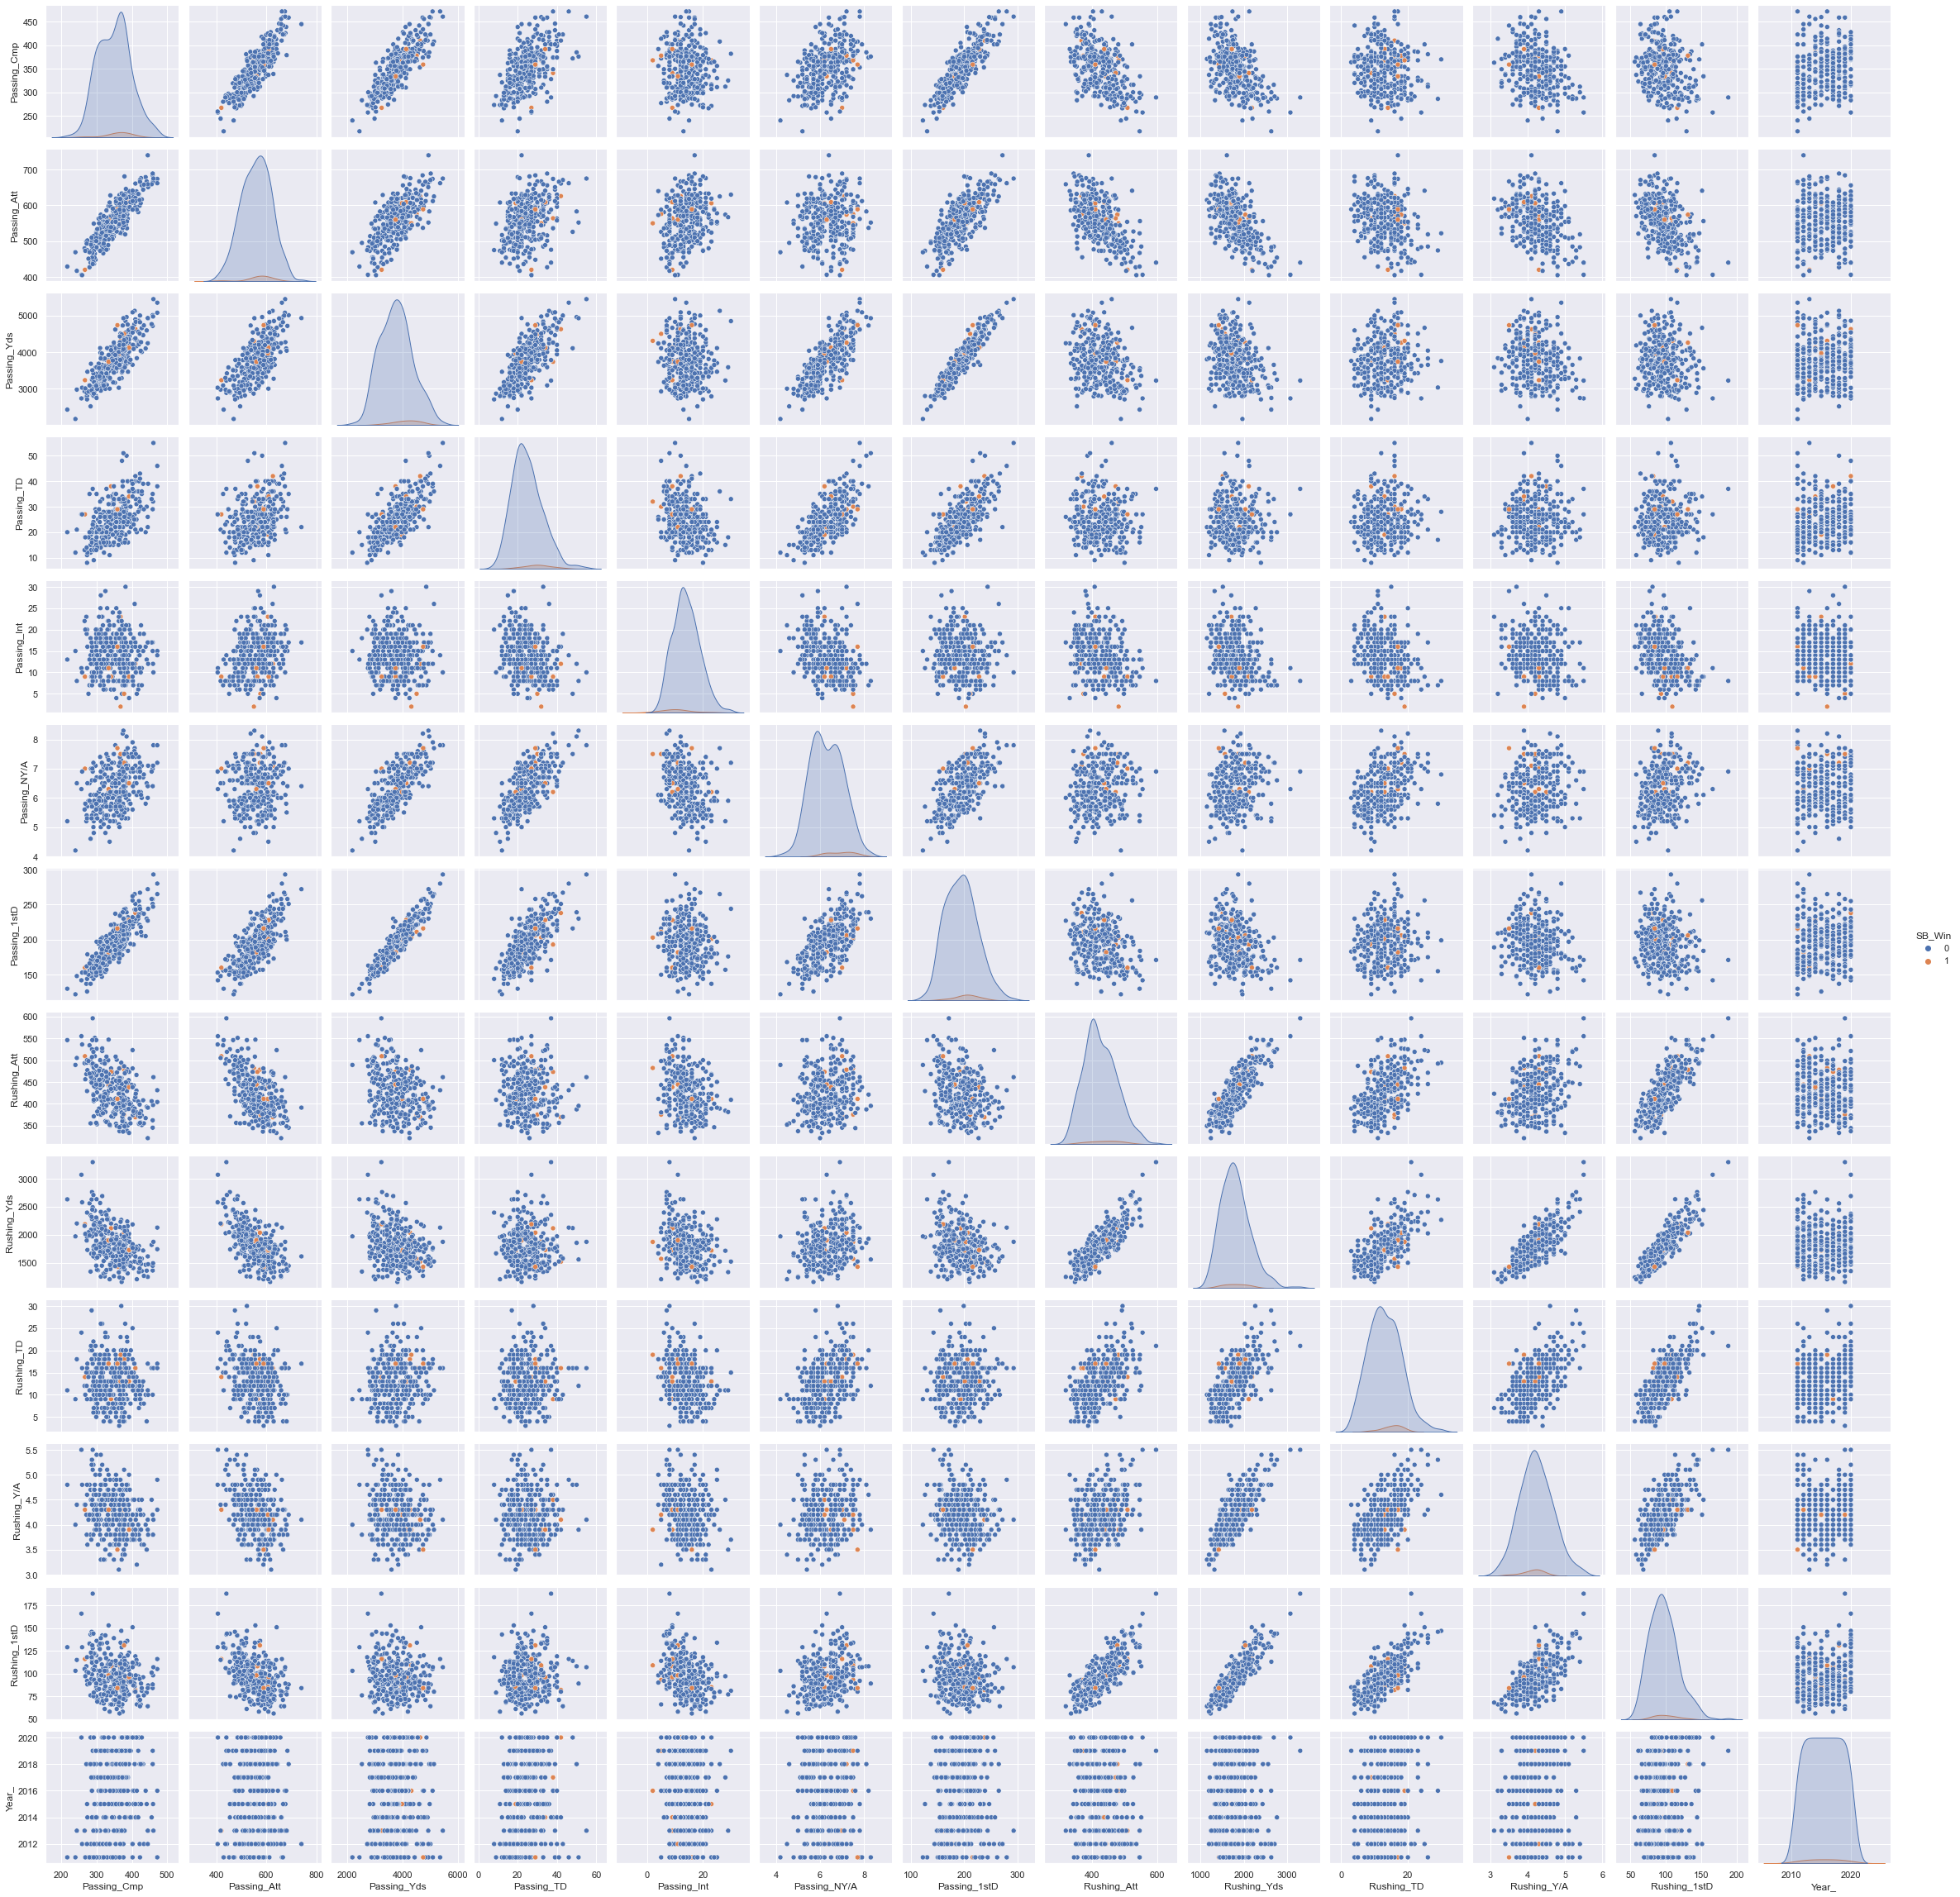

In [385]:
#visualizing some of the data, no clear trends apparent with super bowl wins 
#but some interesting correlations seem to appear

import seaborn as sns
sns.set()

features = ['Passing','Rushing','Year','SB']
dfcopy = MasterOFF[features]

dfcopy.columns = ['_'.join(col) for col in dfcopy.columns]
dfcopy.head()
#dfcopy.info()
sns.pairplot(dfcopy, hue=('SB_Win'));

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Year_', ylabel='TotOff_PF'>

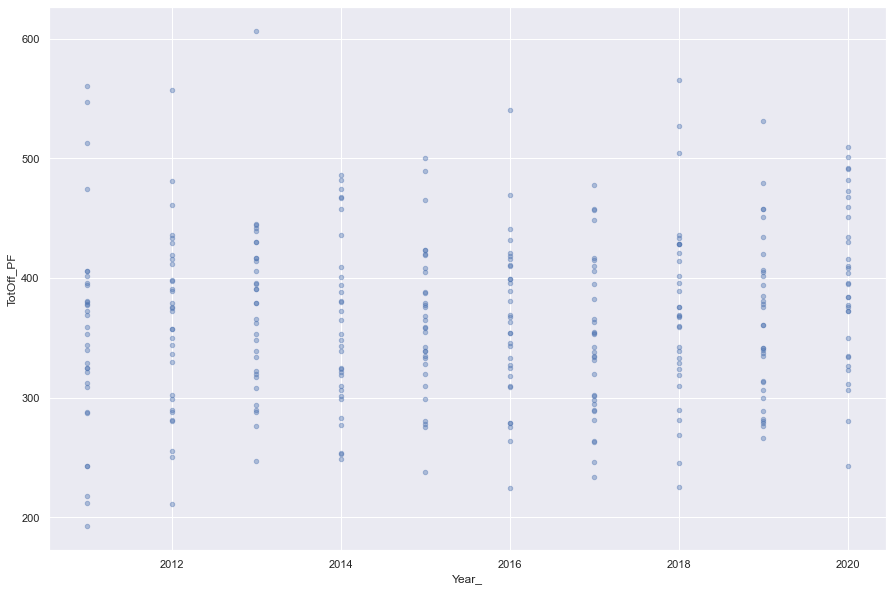

In [390]:
#scatter plot of total offense points scored vs year
MasterOFFcopy = MasterOFF
dfcopy.columns = ['_'.join(col) for col in dfcopy.columns]

MasterOFFcopy.plot.scatter("Year_", "TotOff_PF", figsize=(15, 10), alpha=0.4)

In [395]:
#join levels of the confusing multi-level index
MasterOFFcopy = MasterOFF
MasterOFFcopy.columns = ['_'.join(col) for col in MasterOFFcopy.columns]


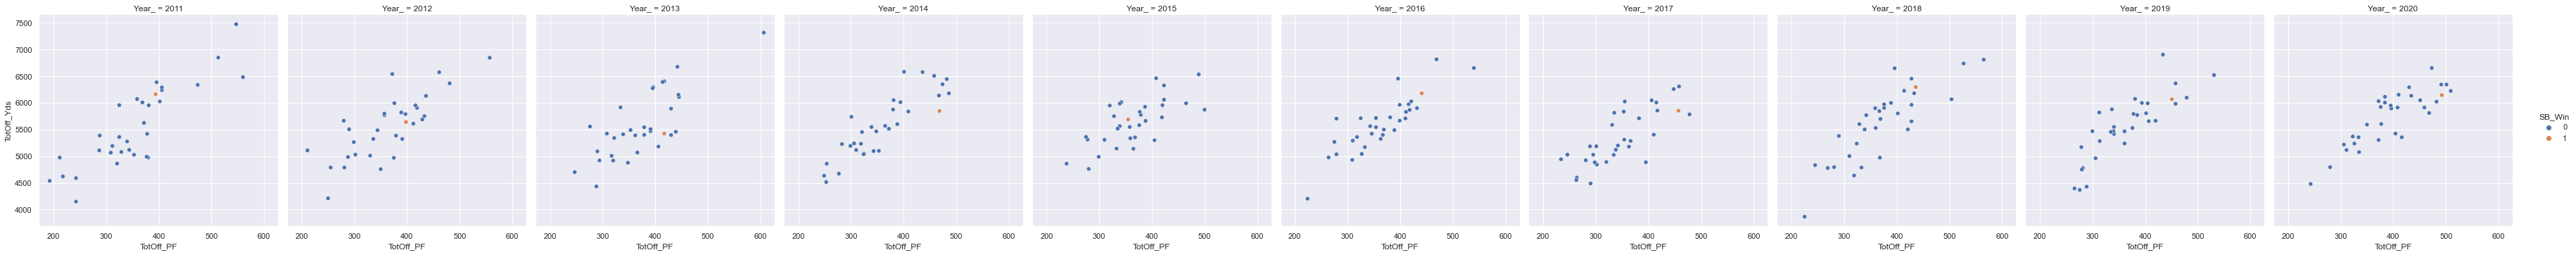

In [394]:
#relationship plot

sns.relplot(
    data=MasterOFFcopy,
    x="TotOff_PF", y="TotOff_Yds", col="Year_", hue="SB_Win")

In [392]:
MasterOFFcopy.corr()

,TotOff_Rk,TotOff_G,TotOff_PF,TotOff_Yds,TotOff_Ply,TotOff_Y/P,TotOff_TO,TotOff_FL,TotOff_1stD,Passing_Cmp,...,Rushing_Y/A,Rushing_1stD,Penalties_Pen,Penalties_Yds,Penalties_1stPy,Score%_Sc%,TurnOver%_TO%,EXP_EXP,Year_,SB_Win
TotOff_Rk,1.000000,NaN,-0.948508,-0.781203,-0.345740,-0.752689,0.439222,0.252628,-0.725953,-0.330179,...,-0.264700,-0.437622,0.041428,0.028976,-0.189373,-0.836639,0.443096,-0.688925,0.000000,-0.186743
TotOff_G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotOff_PF,-0.948508,NaN,1.000000,0.820086,0.377085,0.780439,-0.423991,-0.237777,0.792417,0.392479,...,0.273545,0.457457,-0.077126,-0.053769,0.192259,0.889548,-0.424879,0.779519,0.082008,0.162349
TotOff_Yds,-0.781203,NaN,0.820086,1.000000,0.566441,0.898762,-0.220319,-0.107549,0.905728,0.571572,...,0.293057,0.416505,0.003388,0.024067,0.141288,0.782992,-0.192359,0.736869,0.042168,0.107652
TotOff_Ply,-0.345740,NaN,0.377085,0.566441,1.000000,0.152868,0.081489,0.078546,0.655020,0.526112,...,-0.144748,0.240322,-0.057434,-0.041267,0.210367,0.286234,0.025457,0.253900,-0.067620,0.052439
TotOff_Y/P,-0.752689,NaN,0.780439,0.898762,0.152868,1.000000,-0.311091,-0.173023,0.737937,0.403626,...,0.434702,0.377274,0.032499,0.050726,0.059594,0.789447,-0.247937,0.747503,0.094574,0.107995
TotOff_TO,0.439222,NaN,-0.423991,-0.220319,0.081489,-0.311091,1.000000,0.659264,-0.235801,-0.035575,...,-0.189763,-0.308842,0.041473,0.017177,-0.056727,-0.545312,0.959604,-0.494071,-0.234925,-0.136055
TotOff_FL,0.252628,NaN,-0.237777,-0.107549,0.078546,-0.173023,0.659264,1.000000,-0.110853,-0.044890,...,-0.056379,-0.114253,-0.003523,-0.023674,-0.049767,-0.320786,0.596685,-0.253089,-0.134337,-0.088234
TotOff_1stD,-0.725953,NaN,0.792417,0.905728,0.655020,0.737937,-0.235801,-0.110853,1.000000,0.613553,...,0.204405,0.469483,-0.140158,-0.114214,0.337459,0.791199,-0.182924,0.765578,0.180570,0.087495
Passing_Cmp,-0.330179,NaN,0.392479,0.571572,0.526112,0.403626,-0.035575,-0.044890,0.613553,1.000000,...,-0.271144,-0.254437,-0.033635,-0.004714,0.168006,0.408298,-0.009531,0.434515,0.187359,0.036310
